In [57]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


rawData = pd.read_csv('data/data.scv', sep='\t')
rawData.time = pd.to_datetime(rawData.time)
rawData = rawData.set_index(rawData.time)
rawData = rawData.drop(['time'],axis=1)
#rawData = rawData.drop(['time','dispHeight','wSpeed.850hpa','temperature.50','wDir.850hpa','msl'],axis=1)
rawData['month'] = rawData.index.month
#rawData['year'] = rawData.index.year%4
#rawData['hour'] = rawData.index.hour

rawData.head()

,psfc,msl,wSpeed.50,wDir.50,wSpeed.850hpa,wDir.850hpa,temperature.10,temperature.50,dispHeight,precIceWater,precLiqWater,precWaterVapor,specHumidity.10,month
time,,,,,,,,,,,,,,
1990-01-01 00:00:00,100222.2,101272.5,11.27,259.6,18.02,293.3,-10.63,-11.43,0.1,0.0,1.3,6212.4,1.4,1
1990-01-01 01:00:00,100068.3,101118.8,11.65,261.6,19.68,295.1,-9.37,-10.21,0.1,0.0,0.3,6500.8,1.5,1
1990-01-01 02:00:00,99929.3,100975.7,12.53,267.1,20.97,300.0,-7.51,-8.43,0.1,0.0,0.0,5970.2,1.7,1
1990-01-01 03:00:00,99843.4,100890.6,12.16,272.1,21.43,305.3,-6.51,-7.41,0.1,0.1,0.0,5753.2,1.9,1
1990-01-01 04:00:00,99813.9,100869.8,11.81,279.3,20.91,310.8,-6.38,-7.23,0.1,0.9,6.1,6736.5,1.9,1


In [58]:
temp = rawData['temperature.10']
temp.head()

time
1990-01-01 00:00:00   -10.63
1990-01-01 01:00:00    -9.37
1990-01-01 02:00:00    -7.51
1990-01-01 03:00:00    -6.51
1990-01-01 04:00:00    -6.38
Name: temperature.10, dtype: float64

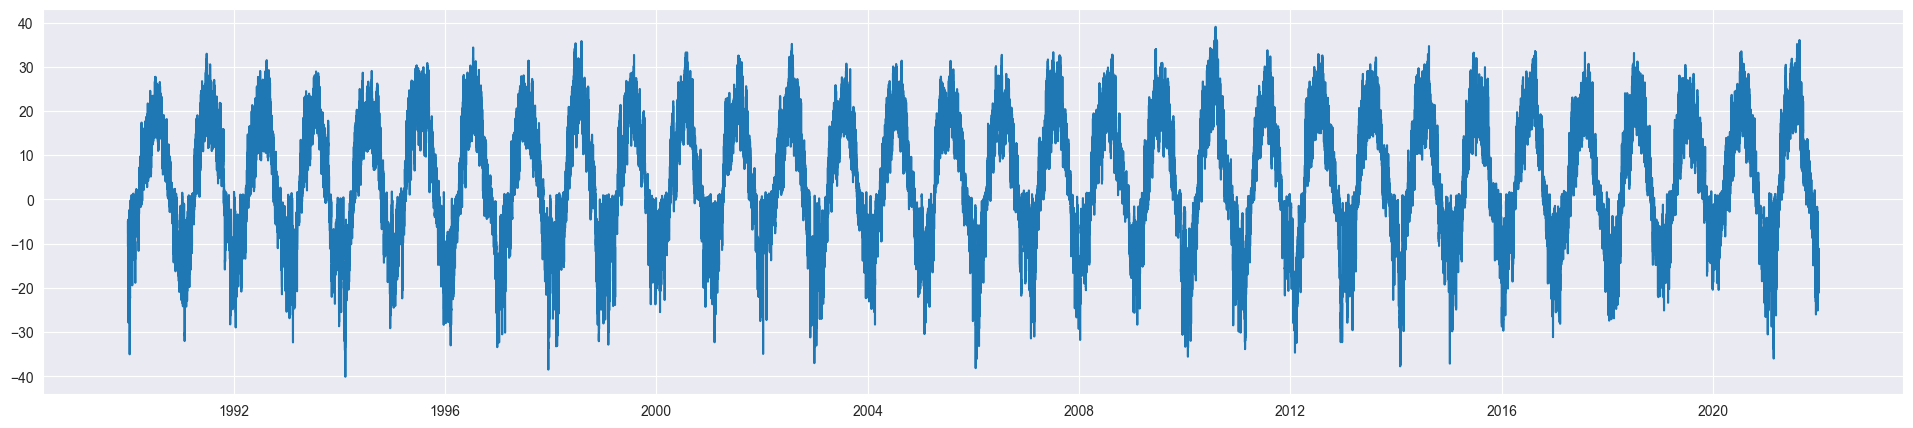

In [59]:
f, ax = plt.subplots()
f.set_size_inches(24,5)

ax.plot(temp)

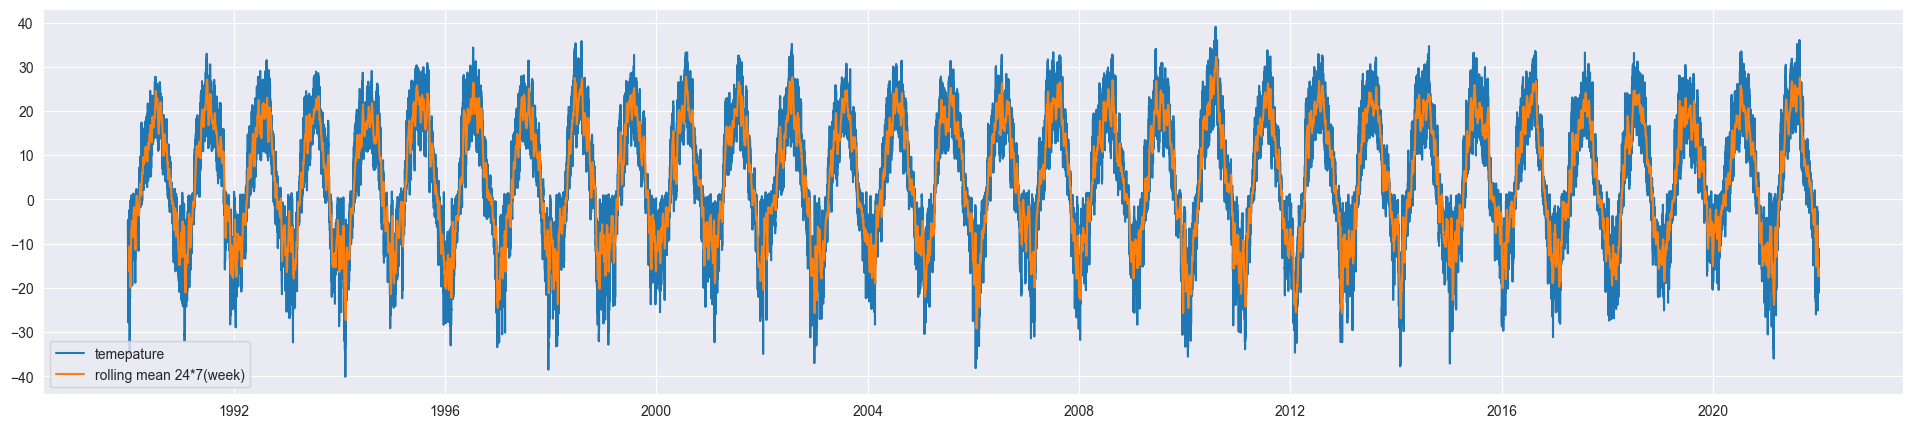

In [60]:
f, ax = plt.subplots()
f.set_size_inches(24, 5)

ax.plot(temp, label = 'temepature')

ax.plot(temp.rolling(window=24*7).mean(), label = 'rolling mean 24*7(week)')
ax.set_label = '123'
ax.legend()

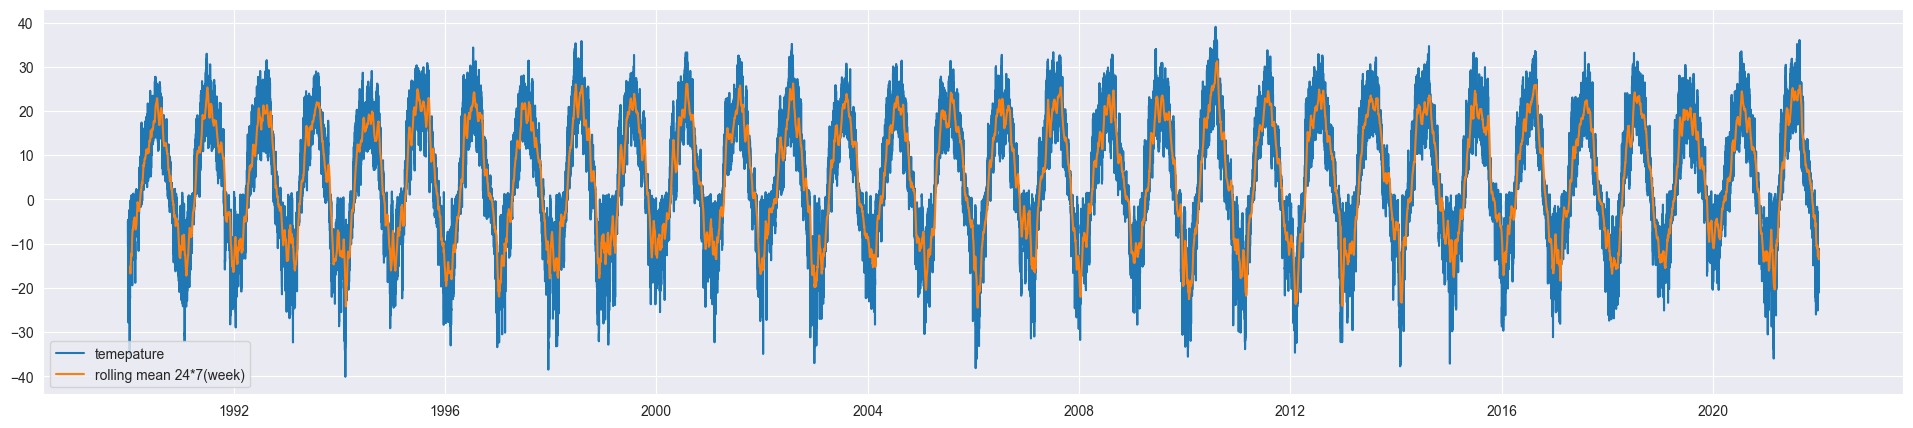

In [61]:
f, ax = plt.subplots()
f.set_size_inches(24, 5)

ax.plot(temp, label = 'temepature')

ax.plot(temp.rolling(window=24*15).mean(), label = 'rolling mean 24*7(week)')
ax.set_label = '123'
ax.legend()

In [62]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

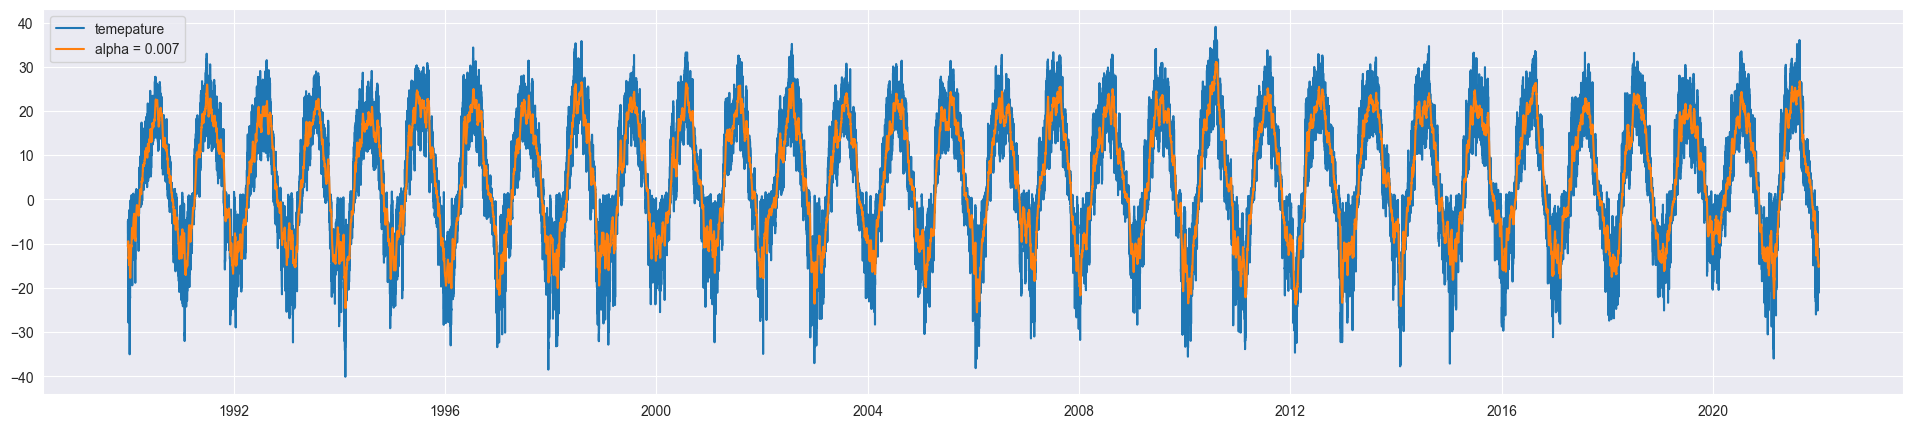

In [63]:
f, ax = plt.subplots()
f.set_size_inches(24, 5)

ax.plot(temp, label = 'temepature')
for alpha in [0.007]:
    ax.plot(temp.index, exponential_smoothing(temp,alpha), label = f'alpha = {alpha}')
ax.legend()

In [64]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

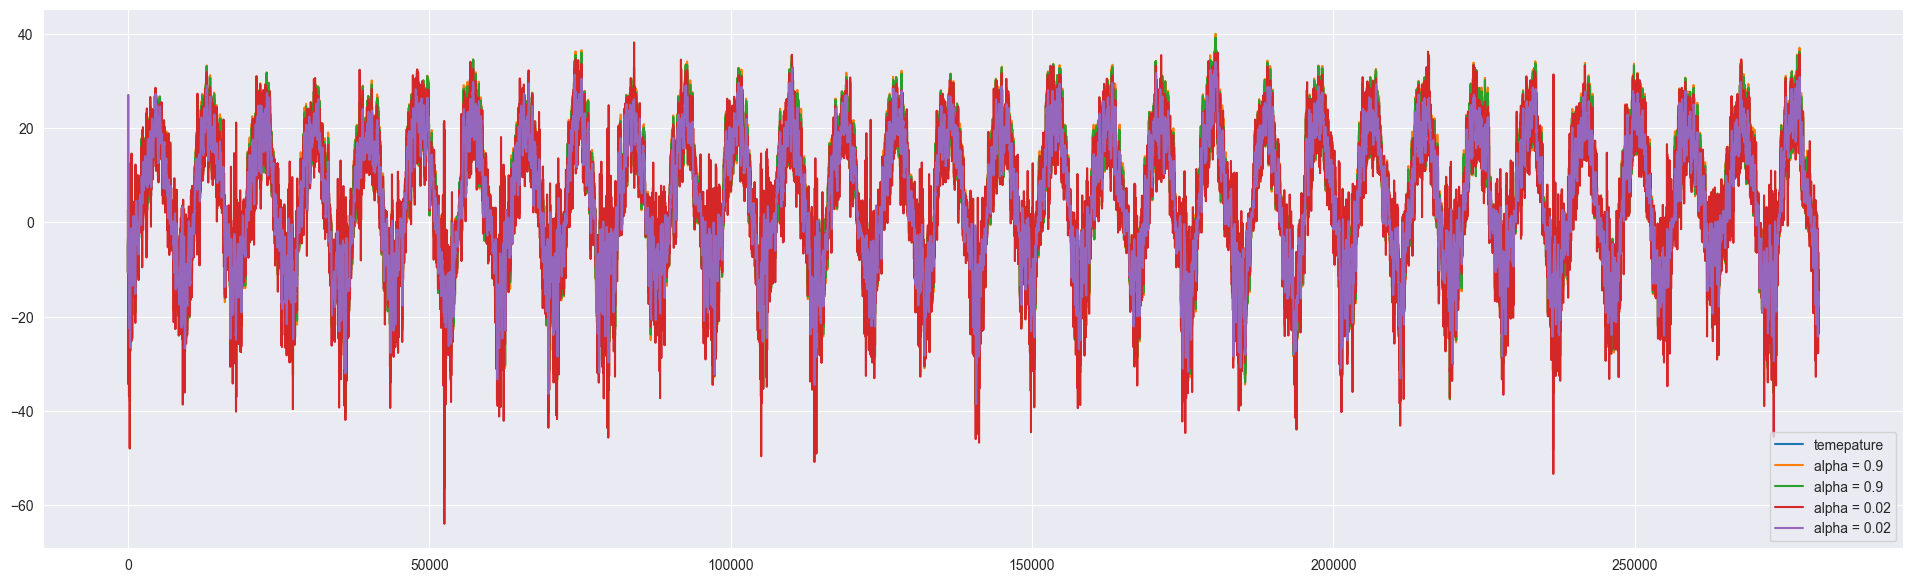

In [65]:
f, ax = plt.subplots()
f.set_size_inches(24, 7)

ax.plot(temp.values, label = 'temepature')
for alpha in [0.9, 0.02]:
    for beta in [0.9, 0.02]:
        ax.plot(double_exponential_smoothing(temp,alpha,beta), label = f'alpha = {alpha}')
ax.legend()

In [66]:
from HoltWinters import HoltWinters
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors))

In [67]:
%%time
data = temp[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

8.064455763445721e-05 9.12362742149786e-05 0.0007464824512354862
CPU times: total: 7min 18s
Wall time: 7min 18s


In [68]:
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [69]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

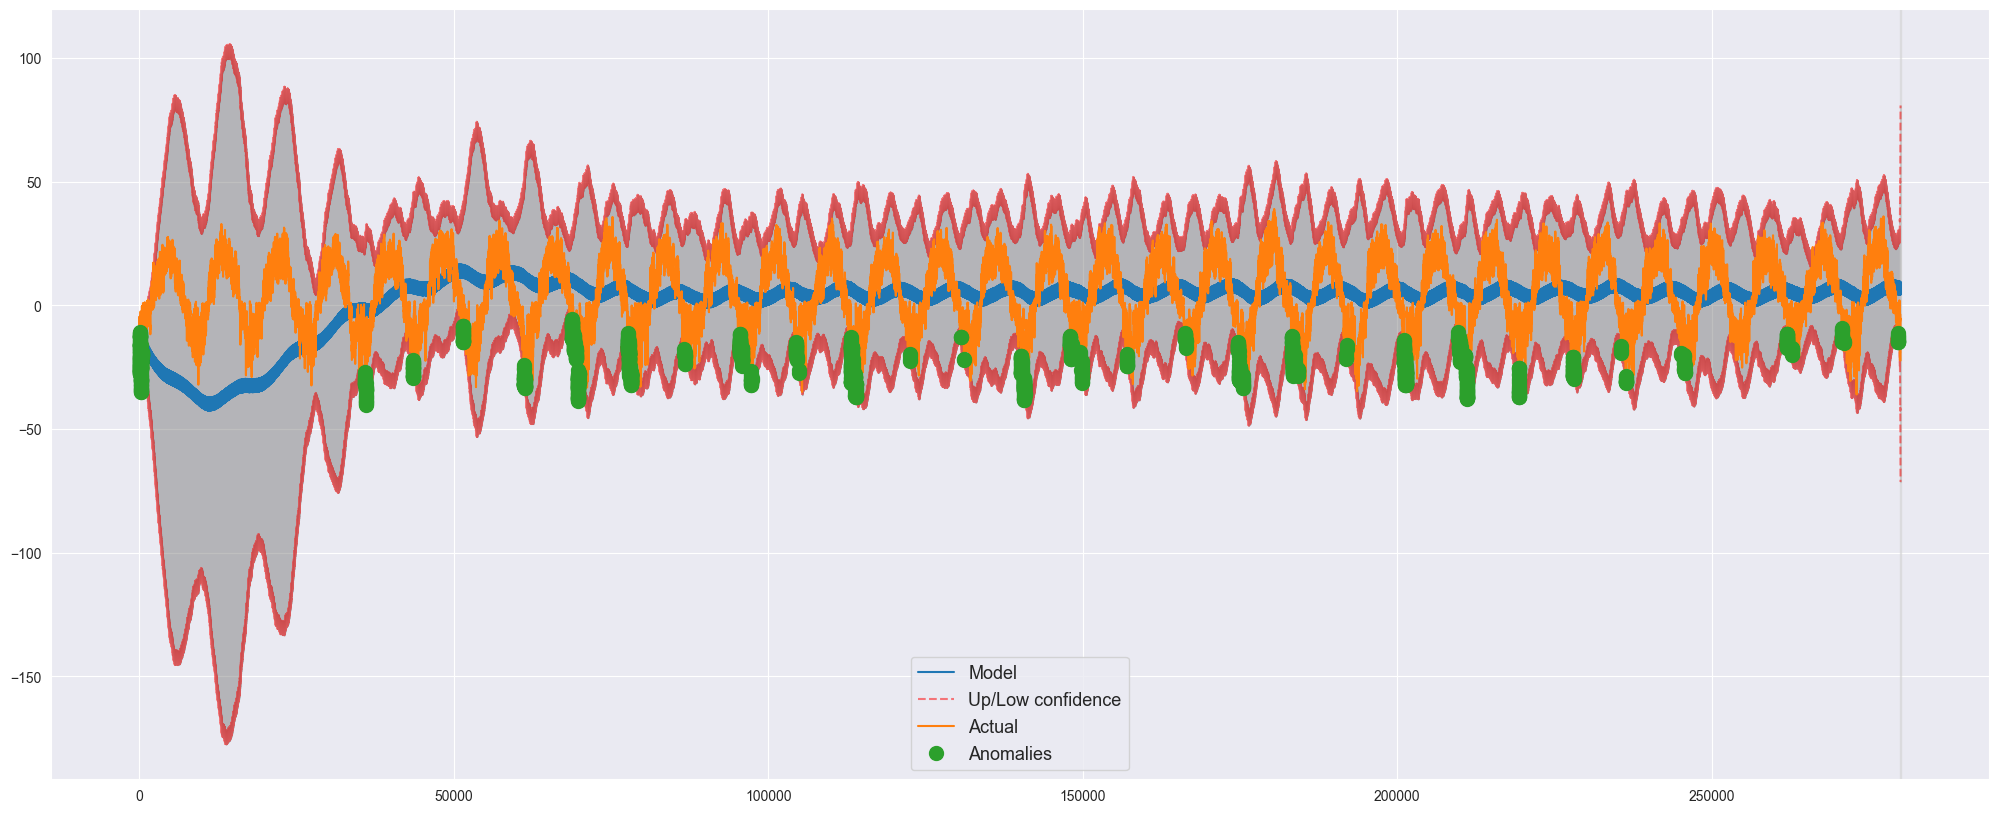

In [70]:
plotHoltWinters()